In [1]:
import os
import sys
from pathlib import Path
import pandas as pd

# Load Data

In [ ]:
gnss_trace_1_pd = pd.read_csv(r'C:\Users\nguye\Documents\GitHub\emtl30kr_gnss_logger\data\20250730_katech\p2_em_10km.csv')
gnss_trace_2_pd = pd.read_csv(r'C:\Users\nguye\Documents\GitHub\emtl30kr_gnss_logger\data\20250730_katech\p2_f9k_10km.csv')

# Pre-processing Data

In [3]:
# filter out unwanted fix types
filterd_fix_types = [
    'fixed-rtk',
    'dead-reckoning',
]

filtered_trace_1_pd = gnss_trace_1_pd[gnss_trace_1_pd['FixType'].isin(filterd_fix_types)]
filtered_trace_2_pd = gnss_trace_2_pd[gnss_trace_2_pd['FixType'].isin(filterd_fix_types)]

# filter out unwanted columns
filtered_columns = ['GNSSTime', 'Latitude', 'Longitude', 'FixType']

filtered_trace_1_pd = filtered_trace_1_pd[filtered_columns]
filtered_trace_2_pd = filtered_trace_2_pd[filtered_columns]


In [4]:
# Trim data to have the closest start and end times
start_time = max(filtered_trace_1_pd['GNSSTime'].min(), filtered_trace_2_pd['GNSSTime'].min())
end_time = min(filtered_trace_1_pd['GNSSTime'].max(), filtered_trace_2_pd['GNSSTime'].max())

filtered_trace_1_pd = filtered_trace_1_pd[(filtered_trace_1_pd['GNSSTime'] >= start_time) & (filtered_trace_1_pd['GNSSTime'] <= end_time)]
filtered_trace_2_pd = filtered_trace_2_pd[(filtered_trace_2_pd['GNSSTime'] >= start_time) & (filtered_trace_2_pd['GNSSTime'] <= end_time)]

# Visualize Traces

In [5]:
import folium
import numpy as np

In [6]:
filtered_trace_1_np = filtered_trace_1_pd[['Latitude', 'Longitude']].to_numpy()
filetered_trace_2_np = filtered_trace_2_pd[['Latitude', 'Longitude']].to_numpy()

# Calculate map center (mean of first trace, or combine for both)
center = [filtered_trace_1_np[:, 0].mean(), filtered_trace_1_np[:, 1].mean()]

# Create Folium map
m = folium.Map(location=center, zoom_start=19, tiles='OpenStreetMap', control_scale=True)
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# Trace 1: Blue
coordinates1 = list(map(tuple, filtered_trace_1_np))
folium.PolyLine(coordinates1, color='blue', weight=3, opacity=0.8, tooltip='Trace 1').add_to(m)
folium.Marker(coordinates1[0], popup='Start 1', icon=folium.Icon(color='green')).add_to(m)
folium.Marker(coordinates1[-1], popup='End 1', icon=folium.Icon(color='red')).add_to(m)

# Trace 2: Orange
coordinates2 = list(map(tuple, filetered_trace_2_np))
folium.PolyLine(coordinates2, color='orange', weight=3, opacity=0.8, tooltip='Trace 2').add_to(m)
folium.Marker(coordinates2[0], popup='Start 2', icon=folium.Icon(color='purple')).add_to(m)
folium.Marker(coordinates2[-1], popup='End 2', icon=folium.Icon(color='darkred')).add_to(m) 

m

# Compare using DWT

In [7]:
from dtw import dtw
from haversine import haversine

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [8]:
# Fix typo in variable name
filtered_trace_1_np = filtered_trace_1_pd[['Latitude', 'Longitude']].to_numpy()
filtered_trace_2_np = filtered_trace_2_pd[['Latitude', 'Longitude']].to_numpy()

# Downsample for speed
downsample_rate = 1
filtered_trace_1_np = filtered_trace_1_np[::downsample_rate]
filtered_trace_2_np = filtered_trace_2_np[::downsample_rate]

# Haversine distance (ensure you have the function)
def gnss_distance(p1, p2):
    # p1 and p2 are (lat, lon) numpy arrays
    return haversine((p1[0], p1[1]), (p2[0], p2[1]), unit='m')

# Run DTW
alignment = dtw(
    filtered_trace_1_np, 
    filtered_trace_2_np,
    dist_method=gnss_distance,
    keep_internals=True)

dtw_distance = alignment.distance
normalized_distance = alignment.normalizedDistance

print(f"DTW distance: {dtw_distance:.2f} m")
print(f"Normalized DTW distance: {normalized_distance:.2f} m")

# The optimal alignment path (indices)
indices = list(zip(alignment.index1, alignment.index2))
# print("Optimal warping path (index pairs):", indices)

# Compute haversine distance at each alignment step
cost_vector = [
    gnss_distance(filtered_trace_1_np[i], filtered_trace_2_np[j])
    for i, j in indices
]
# print("Cost along the optimal path:", cost_vector)


DTW distance: 141.86 m
Normalized DTW distance: 0.05 m


In [9]:
import numpy as np

cost_vector_np = np.array(cost_vector)

threshold = 0.1  # 10cm in meters
count_under_10cm = np.sum(cost_vector_np < threshold)
percent_under_10cm = 100 * count_under_10cm / len(cost_vector_np)

stats = {
    'Min': np.min(cost_vector_np),
    'Max': np.max(cost_vector_np),
    'Mean': np.mean(cost_vector_np),
    'Median': np.median(cost_vector_np),
    'Std': np.std(cost_vector_np),
    'Count < 10cm': int(count_under_10cm),
    'Percent < 10cm (%)': percent_under_10cm
}

# Convert to DataFrame for tabular display
stats_table = pd.DataFrame([
    {'Statistic': k, 
     'Value': f"{v:.4f}" if isinstance(v, float) and 'Percent' not in k and 'Count' not in k else v if isinstance(v, int) else f"{v:.1f}%" if 'Percent' in k else v}
    for k, v in stats.items()
])

print(stats_table.to_string(index=False))


         Statistic  Value
               Min 0.0000
               Max 0.7073
              Mean 0.0592
            Median 0.0891
               Std 0.0763
      Count < 10cm   1650
Percent < 10cm (%)  77.7%


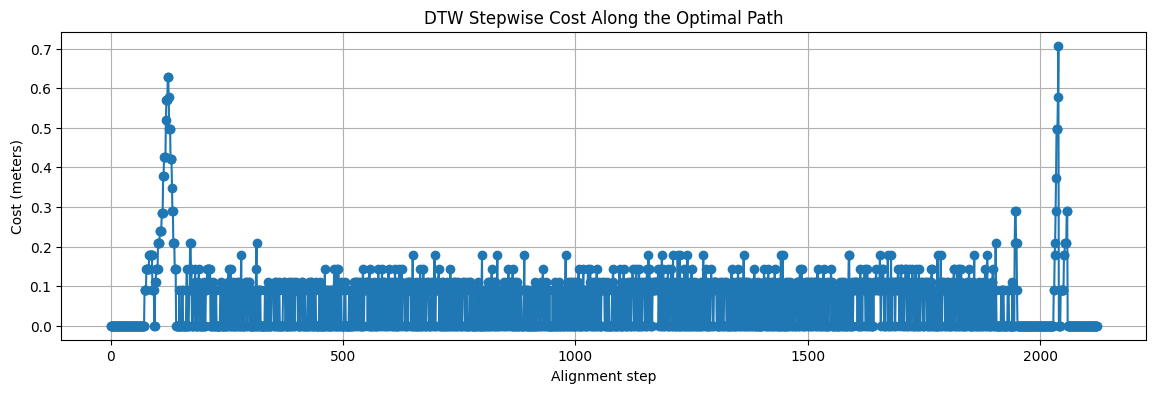

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assume cost_vector is already defined
cost_vector_np = np.array(cost_vector)
plt.figure(figsize=(14, 4))
plt.plot(cost_vector_np, marker='o')
plt.xlabel('Alignment step')
plt.ylabel('Cost (meters)')
plt.title('DTW Stepwise Cost Along the Optimal Path')
plt.grid(True)
plt.show()


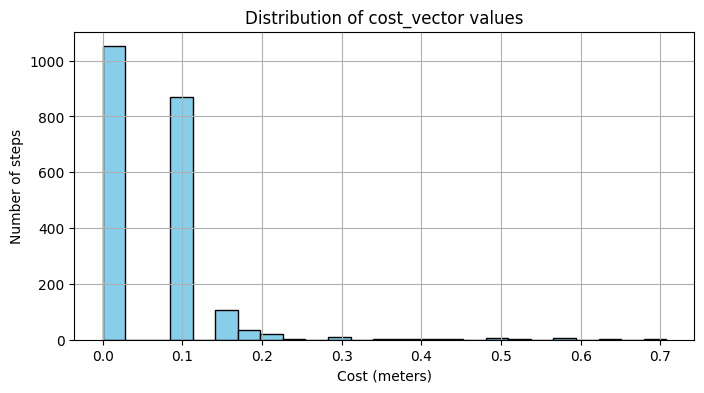

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(cost_vector_np, bins=25, color='skyblue', edgecolor='black')
plt.xlabel('Cost (meters)')
plt.ylabel('Number of steps')
plt.title('Distribution of cost_vector values')
plt.grid(True)
plt.show()
